<a href="https://colab.research.google.com/github/FenryrMKIII/objectDetection-yoloV3-pyTorch/blob/master/Symbol_recognition_pyTorchYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # Install OpenCV lib
# # necessary if OPENCV=1 option is chosen when compiling darknet

# # First update
# !apt-get update
# !apt-get upgrade

# # Then install bunch of stuff necessary to install opencv (don't know why, found that on internet)
# !apt-get install build-essential
# !apt-get install cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev
# !apt-get install libavcodec-dev libavformat-dev libswscale-d

# # Eventually install opencv
# !apt-get install libopencv-dev


In [0]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
# check you are on GPU
# if command fails ... You are not on GPU !!

!nvidia-smi
# check cuda is installed
!cat /proc/driver/nvidia/version # verify driver version
!nvcc -V # verify cuda version

Thu Sep 12 05:02:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# check cuda version
!/usr/local/cuda/bin/nvcc --version

# check linux version
!lsb_release -a

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [0]:
# cuda is different from cuDNN
# that stands for Deep Neural Networks !
# Need to download cuDNN version applicable with installed cuda version !

!mkdir -p "/content/cudnn" 
! cp -r "/content/gdrive/My Drive/cuDNN/cudnn-10.0-linux-x64-v7.6.3.30.tgz" "/content/cudnn"

# cudnn archive was downloaded from nvidia cudnn website, requires free subscription to nvidia website
# download archive for installed cuda version (see output cell above) and choose the "linux library" link (not the linux version specific)
# to get a targz archive (not a deb !)

%cd /content/cudnn
!tar -xzvf cudnn-10.0-linux-x64-v7.6.3.30.tgz
!cp cuda/include/cudnn.h /usr/local/cuda/include # required otherwise compilation of darknet wil fail
!cp cuda/lib64/libcudnn* /usr/local/cuda/lib64 # same story !take care architecture dependent, here 64bits
!chmod a+r /usr/local/cuda/include/cudnn.h /usr/local/cuda/lib64/libcudnn* # make file property adequate

/content/cudnn
cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.3
cuda/lib64/libcudnn_static.a


In [0]:
# download AlexeyAB version of darknet
# this is an improved version of darknet
%cd /content/
!git clone https://github.com/AlexeyAB/darknet.git

/content
Cloning into 'darknet'...
remote: Enumerating objects: 10884, done.
remote: Total 10884 (delta 0), reused 0 (delta 0), pack-reused 10884
Receiving objects: 100% (10884/10884), 10.35 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (7374/7374), done.


In [0]:
# one will now compile darknet with chosen options
%cd darknet/
!cp Makefile Makefile.example # just save original file
!cp Makefile.example Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
#!sed -i 's/local\/cuda/usr\/local\/cuda/g' Makefile # replace cuda link
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile # THIS LINE IS THE ISSUE !!
# !sed -i 's/OPENMP=0/OPENMP=1/g' Makefile # This if for working with CPU
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile

/content/darknet


In [0]:
# to verify makefile
from google.colab import files
files.download('Makefile')
files.download('Makefile.example')

In [0]:
# to download yolo source file (original)
# to check before modification
from google.colab import files
files.download('src/yolo_layer.c')
files.download('src/parser.c')

In [0]:
# download modified yolo source files
!cp -r /content/gdrive/My\ Drive/dataManagement/symbolRecognition/parserWithSpaces.c .
# replace original ones by modified ones
!rm -rf '/content/darknet/src/parser.c'

!mv parserWithSpaces.c '/content/darknet/src/parser.c'  # modified to allow whitespaces in the name of the backup directory e.g. My Drive
                                                        # usage is : /content/gdrive/My$Drive/SomePath i.e. $ represents the space and gets replaced in the modified yolo code

In [0]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:896:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘image image_data_augmentation(mat_cv*, int, int, int, int, int, int, int, float, float, float, int, int, float*)’:
./src/image_opencv.cpp:1211:26: warning: variable ‘kernel_size’ set but not used [-Wunused-but-set-variable]
                 cv::Size kernel_size = cv::Size(ksize, ksize);
                          ^~~~~

   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256       3 x 3/ 2    104 x 104 x 128 ->   52 x  52 x 256 1.595 BF
  13 conv    128       1 x 1/ 1     52 x  52 x 256 ->   52 x  5

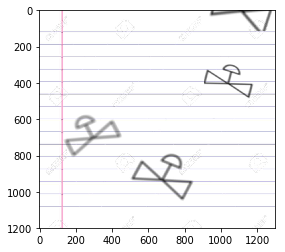

In [0]:
# test the model on a picture stored on my google drive
# fetchpre-trained weights
import os
if not "yolov3.weights" in os.listdir():
  !wget https://pjreddie.com/media/files/yolov3.weights 
# one is now located in darknet directory
!./darknet detect cfg/yolov3.cfg yolov3.weights '/content/gdrive/My Drive/dataManagement/symbolRecognition/training_sample_0.png'

# Show the detection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
test_image = mpimg.imread(os.path.join("predictions.jpg")) # predicted image is saved in darknet directory ... Clever way to do that ??
plt.imshow(test_image)
plt.axis("on")
plt.show()

# download locally if desired
from google.colab import files
files.download("predictions.jpg")

In [0]:
# define dataset path
datasetPath = "/content/darknet/trainingSet/"

# unzip training data in datasetPath
# zipping is the efficient way to transfer data on google drive via the GUI

!unzip "/content/gdrive/My Drive/dataManagement/symbolRecognition/trainingSet.zip"

Archive:  /content/gdrive/My Drive/dataManagement/symbolRecognition/trainingSet.zip
   creating: trainingSet/
  inflating: trainingSet/training_sample_0.png  
  inflating: trainingSet/training_sample_0.txt  
  inflating: trainingSet/training_sample_1.png  
  inflating: trainingSet/training_sample_1.txt  
  inflating: trainingSet/training_sample_10.png  
  inflating: trainingSet/training_sample_10.txt  
  inflating: trainingSet/training_sample_100.png  
  inflating: trainingSet/training_sample_100.txt  
  inflating: trainingSet/training_sample_101.png  
 extracting: trainingSet/training_sample_101.txt  
  inflating: trainingSet/training_sample_102.png  
  inflating: trainingSet/training_sample_102.txt  
  inflating: trainingSet/training_sample_103.png  
 extracting: trainingSet/training_sample_103.txt  
  inflating: trainingSet/training_sample_104.png  
 extracting: trainingSet/training_sample_104.txt  
  inflating: trainingSet/training_sample_105.png  
 extracting: trainingSet/training

In [0]:
# download original yolov3 config file
# this is the file that needs to be modified when training yolo on own dataset
files.download('cfg/yolov3.cfg') 

# Note that this is only for information
# now that a cfg template I made exists

In [0]:
# Modify the config template 
# (made by myself with placeholder)
# to match the desired parameters

nbClass = 1

batchSize = 32 # The bigger the better
subdivisions = 8 # The smaller the better. This is a "sub-batch" so must be consistent with batchSize
maxBatches = nbClass * 2000
steps = [10,20] # steps define when the learning rate will be modified
steps = ','.join('{:d}'.format(step) for step in steps) 
scales = [0.1, 0.1]
scales = ','.join('{:1.2f}'.format(scale) for scale in scales) 
classes = 1 # number of different classes of object to be recognized
filters = (classes + 5)*3

"""
Generally filters depends on the classes, coords and number of masks, 
i.e. filters=(classes + coords + 1)*<number of mask>, 
where mask is indices of anchors. If mask is absence, 
then filters=(classes + coords + 1)*num)
In the given formula in original yolo Readme coords = 4 since one gives
xcenter, ycenter, picture width, picture height
"""
 
# copy templated config file
!cp -r ../gdrive/My\ Drive/dataManagement/symbolRecognition/yolov3_templated.cfg cfg/yolov3_templated.cfg

# replace desired templated placeholders
replacements = {'%batchSize%':batchSize, 
                '%subdivisions%':subdivisions,
                '%maxBatches%':maxBatches,
               '%steps%':steps, '%scales%':scales,
               '%classes%':classes, '%filters%':filters}

!cp -r cfg/yolov3_templated.cfg cfg/yolov3_myConfig.cfg

with open('cfg/yolov3_templated.cfg') as infile, open('cfg/yolov3_myConfig.cfg', 'w') as outfile:
    for line in infile:
        for src, target in replacements.items():
            line = line.replace(src, str(target))
        outfile.write(line)

from google.colab import files
files.download('cfg/yolov3_myConfig.cfg')

In [0]:
# create the obj.names file for personal training set
persoTrainingSet = "symbols"
objNames = ["valve"]
with open('data/' + persoTrainingSet + '.names', "w+") as f:
  for item in objNames:
    f.write(item + '\n')
 
files.download('data/' + persoTrainingSet + '.names')

In [0]:
import os 
from random import shuffle

# Create associated training & validation set
validRatio = 0.2

extensions = ['.jpg', '.jpeg', '.png']
pictureList = os.listdir(datasetPath)
pictureList = [picture for picture in pictureList if os.path.splitext(picture)[1] in extensions]
shuffle(pictureList)
nbTrainingSamples = round((1-validRatio)*len(pictureList))
trainSet = pictureList[0:nbTrainingSamples]
validSet = pictureList[nbTrainingSamples:]

# write associated files
with open('data/train.txt', 'w+') as f:
  for picture in trainSet:
    f.write(os.path.join(datasetPath + picture + os.linesep)) 
files.download('data/train.txt')

with open('data/test.txt', 'w+') as f:
  for picture in validSet:
    f.write(os.path.join(datasetPath + picture + os.linesep))
files.download('data/test.txt')



# create the obj.data for personal training set
trainingFilePath =  "data/train.txt" # Path to the training file 
                                 # training file shall identify where each picture ".jpg" is located 
                                 # YOLO will automatically associated the bbox coordinates ".txt" given the 
                                 # ".jpg" name 
validationFilePath = "data/test.txt" # same for validation set



with open('data/' + persoTrainingSet + '.data', "w+") as f:
    f.write("classes=" + str(nbClass) + os.linesep)
    f.write("train = data/train.txt" + os.linesep)
    f.write("valid = data/test.txt" + os.linesep)
    f.write("names = data/" + persoTrainingSet + ".names" + os.linesep)
    f.write("backup = /content/gdrive/My$Drive/dataManagement/symbolRecognition/ " + os.linesep)
 
files.download('data/' + persoTrainingSet + '.data')

In [0]:
# Train the network
objData = 'data/' + persoTrainingSet + '.data'

# download trainable weights
if not "darknet53.conv.74" in os.listdir():
  !wget https://pjreddie.com/media/files/darknet53.conv.74
# one is now located in darknet directory

!./darknet detector train $objData cfg/yolov3_myConfig.cfg darknet53.conv.74 -dont_show

In [0]:
# Modify the config template for testing
nbClass = 1
batchSize = 1
subdivisions = 1
maxBatches = nbClass * 2000
steps = [10,20] # steps define when the learning rate will be modified
steps = ','.join('{:d}'.format(step) for step in steps) 
scales = [0.1, 0.1]
scales = ','.join('{:1.2f}'.format(scale) for scale in scales) 
classes = 1 # number of different classes of object to be recognized
filters = (classes + 5)*3
 
# copy templated config file
!cp -r ../gdrive/My\ Drive/dataManagement/symbolRecognition/yolov3_templated.cfg cfg/yolov3_templated.cfg

# replace desired templated placeholders
replacements = {'%batchSize%':batchSize, 
                '%subdivisions%':subdivisions,
                '%maxBatches%':maxBatches,
               '%steps%':steps, '%scales%':scales,
               '%classes%':classes, '%filters%':filters}

!cp -r cfg/yolov3_templated.cfg cfg/yolov3_myTesting.cfg

with open('cfg/yolov3_templated.cfg') as infile, open('cfg/yolov3_myTesting.cfg', 'w') as outfile:
    for line in infile:
        for src, target in replacements.items():
            line = line.replace(src, str(target))
        outfile.write(line)

from google.colab import files
files.download('cfg/yolov3_myTesting.cfg')

In [0]:
# Test the network
# prepare config
objData = 'data/' + persoTrainingSet + '.data'

# download trained weights
!cp -r ../gdrive/My\ Drive/dataManagement/symbolRecognition/yolov3_myConfig_2000.weights yolov3_myConfig_2000.weights

# get a testing picture
test = []
with  open(r'/content/darknet/data/test.txt', mode='r') as f:
  for line in f:
    test.append(line.strip())

   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256       3 x 3/ 2    104 x 104 x 128 ->   52 x  52 x 256 1.595 BF
  13 conv    128       1 x 1/ 1     52 x  52 x 256 ->   52 x  5

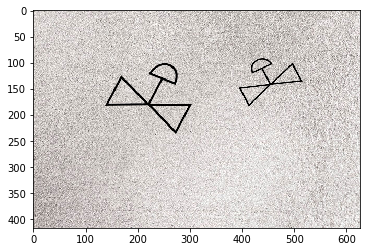

In [0]:
# test the network
# actually test 
import numpy as np
testingPic = test[np.random.randint(len(test))]
testingPic = test[10]

!./darknet detector test $objData cfg/yolov3_myTesting.cfg yolov3_myConfig_2000.weights -dont_show $testingPic

# Show the detection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
test_image = mpimg.imread(os.path.join("predictions.jpg")) # predicted image is saved in darknet directory ... Clever way to do that ??
plt.imshow(test_image)
plt.axis("on")
plt.show()

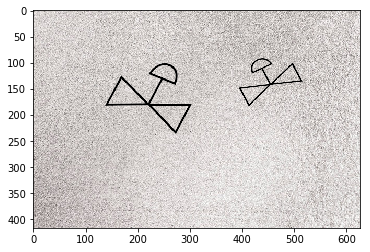

In [0]:
testingPic = test[10]
test_image = mpimg.imread(os.path.join(testingPic)) # predicted image is saved in darknet directory ... Clever way to do that ??
plt.imshow(test_image)
plt.axis("on")
plt.show()

In [0]:
!ls /content/darknet/

3rdparty		darknet.py	       obj
appveyor.yml		darknet_video.py       README.md
backup			data		       results
build			image_yolov2.sh        scripts
build.ps1		image_yolov3.sh        src
build.sh		include		       trainingSet
cfg			json_mjpeg_streams.sh  video_v2.sh
cmake			LICENSE		       video_yolov3.sh
CMakeLists.txt		Makefile	       yolov3_myConfig_2000.weights
darknet			Makefile.example
DarknetConfig.cmake.in	net_cam_v3.sh


In [0]:
# compute anchors
!./darknet detector calc_anchors keys/keys.data -num_of_clusters 9 -width 416 -height 416 # the width and height are set according to config file

# don't forget to adapt number of filters 
# don't forget to adapt number of classes
# don't forget to adapt anchors

In [0]:
# reupload modified cfg with modified anchors
!rm -r keys/yolov3-keys.cfg
!cp -r '$cfg_path/yolov3-keys.cfg' '/content/darknet/keys/.' # remote or local, same configuration for those files

In [0]:
import os
cfg_test_path = '/content/gdrive/My Drive/HandsOnAI/defi2/yolo-cfg/fullSet-cfg-remote-multiClasses'
!cp -r '$cfg_test_path/yolov3-keys-testing.cfg' 'keys/.'

# cycle through weights
path = '/content/gdrive/My Drive/HandsOnAI/defi2/yolo_weights_backup/model2'
for weight in os.listdir(path):
  !cp -r '$path/$weight' .
  !./darknet detector test -dont_show keys/keys.data keys/yolov3-keys-testing.cfg $weight  '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_3_202.jpg' # !! TAKE CARE CONFIG CHANGES FOR TRAINING
  os.rename('predictions.jpg', 'predictions_'+weight+'.jpg')
  
# save predictions to a google drive directory
!rsync -a -v *predictions* '/content/gdrive/My Drive/HandsOnAI/defi2/predictions_backup/model2/picture2'

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

FileNotFoundError: ignored

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

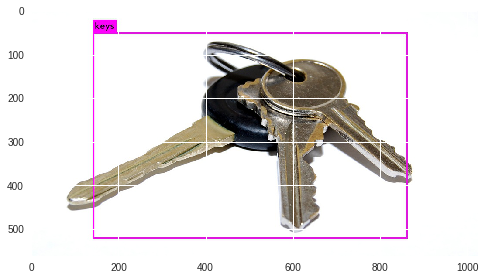

In [0]:
# test the model on a picture stored on my google drive
# one is now located in darknet directory
!cp -r '/content/gdrive/My Drive/HandsOnAI/defi2/yolo_weights_backup/model2/yolov3-keys_3100.weights' .
!./darknet detector test keys/keys.data keys/yolov3-keys-testing.cfg yolov3-keys_3100.weights '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_3_202.jpg' -thresh 0.25


# difficut picture 
# jeremy_bulle/keys_dataset1__20181018_095240.jpg' 


# Show the detection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
test_image = mpimg.imread(os.path.join("predictions.jpg")) # predicted image is saved in darknet directory ... Clever way to do that ??
plt.imshow(test_image)
plt.axis("on")
plt.show()

In [0]:
# validation
#!./darknet detector valid -dont_show keys/keys.data keys/yolov3-keys-test.cfg yolov3-keys_3700.weights

# recall & accuracy
!./darknet detector map keys/keys.data keys/yolov3-keys-testing.cfg yolov3-keys_3100.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [0]:
!rm -r '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_7_186.jpg'
!rm -r '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/umons/umons_159.jpg'
!rm -r '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_7_keys_3_6.jpg'
!rm -r '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_7_124.jpg'
!rm -r '/content/gdrive/My Drive/HandsOnAI/defi2/training_data_YOLO/full/maxime_de_wolf/maxime_7_159.jpg'

#curated
#maxime_7_keys_3_6.jpg
#maxime_7_186
#umons/umons_159.jpg
#maxime_7_124.jpg
#maxime_7_159